#Exploring tabular data with pandas

In this notebook, we will explore a time series of water levels at the Point Atkinson lighthouse using pandas. This is a basic introduction to pandas and we touch on the following topics:

* Reading a csv file
* Simple plots
* Indexing and subsetting
* DatetimeIndex
* Grouping
* Time series methods

 
##Getting started

You will need to have the python libraries pandas, numpy and matplotlib installed. These are all available through the Anaconda distribution of python.

* https://store.continuum.io/cshop/anaconda/

##Resources

There is a wealth of information in the pandas documentation.

* http://pandas.pydata.org/pandas-docs/stable/

Water level data (7795-01-JAN-2000_slev.csv) is from Fisheries and Oceans Canada and is available at this website:
* http://www.isdm-gdsi.gc.ca/isdm-gdsi/twl-mne/index-eng.htm

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import datetime
import numpy as np

%matplotlib inline

##Read the data

It is helpful to understand the structure of your dataset before attempting to read it with pandas.

In [2]:
!head 7795-01-JAN-2000_slev.csv

Station_Name,Point Atkinson, B.C.
Station_Number,7795
Latitude_Decimal_Degrees,49.337
Longitude_Decimal_Degrees,123.253
Datum,CD
Time_zone,UTC
SLEV=Observed Water Level
Obs_date,SLEV(metres)
2000/01/01 08:00,2.95,
2000/01/01 09:00,3.34,


This dataset contains comma separated values. It has a few rows of metadata (station name, longitude, latitude, etc).The actual data begins with timestamps and water level records at row 9. We can read this data with a pandas function read_csv().

read_csv() has many arguments to help customize the reading of many different csv files. For this file, we will
* skip the first 8 rows
* use index_col=False so that the first column is treated as data and not an index
* tell pandas to read the first column as dates (parse_dates=[0])
* name the columns as 'date' and 'wlev'.

In [3]:
data = pd.read_csv('7795-01-JAN-2000_slev.csv', skiprows = 8,
                    index_col=False, parse_dates=[0], names=['date','wlev'])

data is a DataFrame object

In [4]:
type(data)

pandas.core.frame.DataFrame

Let's take a quick peak at the dataset.

In [5]:
data.head()

,date,wlev
0,2000-01-01 08:00:00,2.95
1,2000-01-01 09:00:00,3.34
2,2000-01-01 10:00:00,3.61
3,2000-01-01 11:00:00,3.69
4,2000-01-01 12:00:00,3.63


In [6]:
data.tail()

,date,wlev
87603,2009-12-31 04:00:00,1.41
87604,2009-12-31 05:00:00,0.69
87605,2009-12-31 06:00:00,0.30
87606,2009-12-31 07:00:00,0.34
87607,2009-12-31 08:00:00,0.83


In [7]:
data.describe()

,wlev
count,87608.000000
mean,3.093610
std,1.053402
min,-0.200000
25%,2.370000
50%,3.320000
75%,3.910000
max,5.490000


Notice that pandas did not apply the summary statistics to the date column.

##Simple Plots

pandas has support for some simple plotting features, like line plots, scatter plots, box plots, etc. For  full overview of plots visit http://pandas.pydata.org/pandas-docs/stable/visualization.html

Plotting is really easy. pandas even takes care of labels and legends.

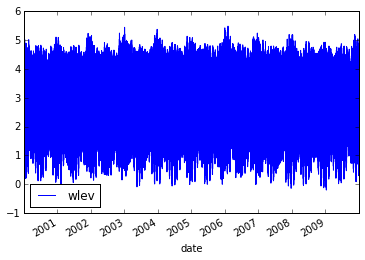

In [8]:
data.plot('date','wlev')

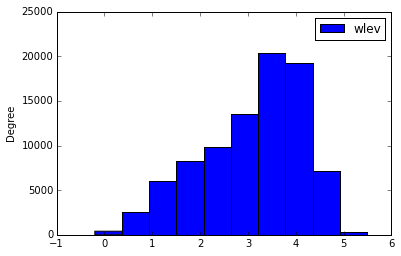

In [9]:
data.plot(kind='hist')

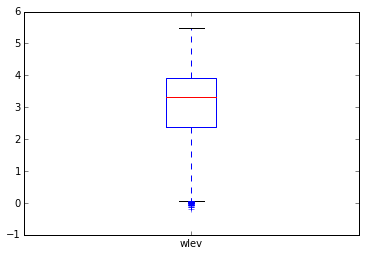

In [10]:
data.plot(kind='box')

##Indexing and Subsetting

We can index and subset the data in different ways.

###By row number

For example, grab the first two rows.

In [11]:
data[0:2]

,date,wlev
0,2000-01-01 08:00:00,2.95
1,2000-01-01 09:00:00,3.34


Note that accessing a single row by the row number doesn't work!

In [13]:
data[0]

KeyError: 0

In that case, I would recommend using .iloc or slice for one row. 

In [14]:
data.iloc[0]

date    2000-01-01 08:00:00
wlev                   2.95
Name: 0, dtype: object

In [15]:
data[0:1]

,date,wlev
0,2000-01-01 08:00:00,2.95


### By column

For example, print the first few lines of the wlev column.

In [16]:
data['wlev'].head()

0    2.95
1    3.34
2    3.61
3    3.69
4    3.63
Name: wlev, dtype: float64

### By a condition

For example, subset the data with date greater than Jan 1, 2008. We pass our condition into the square brackets of data.

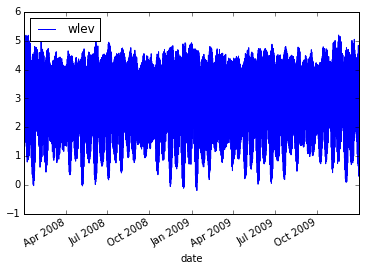

In [17]:
data_20082009 = data[data['date']>datetime.datetime(2008,1,1)]
data_20082009.plot('date','wlev')

###Mulitple conditions

For example, look for extreme water level events. That is, instances where the water level is above 5 m or below 0 m.

Don't forget to put brackets () around each part of the condition.

In [19]:
data_extreme = data[(data['wlev']>5) | (data['wlev']<0)]
data_extreme.head()

,date,wlev
200,2000-01-09 16:00:00,5.03
1255,2000-02-22 16:00:00,5.02
8407,2000-12-16 18:00:00,5.11
8408,2000-12-16 19:00:00,5.05
9003,2001-01-10 14:00:00,5.04


### Exercise

What was the maximum water level in 2006? 

Bonus: When?

####Solution

Isolate the year 2006. Use describe to look up the max water level.

In [20]:
data_2006 = data[(data['date']>=datetime.datetime(2006,1,1)) & (data['date'] < datetime.datetime(2007,1,1))]
data_2006.describe()

,wlev
count,8756.000000
mean,3.142052
std,1.077604
min,-0.010000
25%,2.400000
50%,3.380000
75%,3.970000
max,5.490000


The max water level is 5.49m. Use a condition to determine the date.

In [21]:
date_max  = data_2006[data_2006['wlev']==5.49]['date']
print date_max

53399   2006-02-04 17:00:00
Name: date, dtype: datetime64[ns]


##Manipulating dates

In the above example, it would have been convenient if we could access only the year part of the time stamp. But this doesn't work:

In [22]:
data['date'].year

AttributeError: 'Series' object has no attribute 'year'

We can use the pandas DatetimeIndex class to make this work. The DatetimeIndex allows us to easily access properties, like year, month, and day of each timestamp. We will use this to add new Year, Month, Day, Hour and DayOfYear columns to the dataframe.

In [23]:
date_index = pd.DatetimeIndex(data['date'])
print date_index

DatetimeIndex(['2000-01-01 08:00:00', '2000-01-01 09:00:00',
               '2000-01-01 10:00:00', '2000-01-01 11:00:00',
               '2000-01-01 12:00:00', '2000-01-01 13:00:00',
               '2000-01-01 14:00:00', '2000-01-01 15:00:00',
               '2000-01-01 16:00:00', '2000-01-01 17:00:00', 
               ...
               '2009-12-30 23:00:00', '2009-12-31 00:00:00',
               '2009-12-31 01:00:00', '2009-12-31 02:00:00',
               '2009-12-31 03:00:00', '2009-12-31 04:00:00',
               '2009-12-31 05:00:00', '2009-12-31 06:00:00',
               '2009-12-31 07:00:00', '2009-12-31 08:00:00'],
              dtype='datetime64[ns]', length=87608, freq=None, tz=None)


In [24]:
data['Day'] = date_index.day
data['Month'] = date_index.month
data['Year'] = date_index.year
data['Hour'] = date_index.hour
data['DayOfYear'] = date_index.dayofyear

In [25]:
data.head()

,date,wlev,Day,Month,Year,Hour,DayOfYear
0,2000-01-01 08:00:00,2.95,1,1,2000,8,1
1,2000-01-01 09:00:00,3.34,1,1,2000,9,1
2,2000-01-01 10:00:00,3.61,1,1,2000,10,1
3,2000-01-01 11:00:00,3.69,1,1,2000,11,1
4,2000-01-01 12:00:00,3.63,1,1,2000,12,1


In [26]:
data.describe()

,wlev,Day,Month,Year,Hour,DayOfYear
count,87608.000000,87608.000000,87608.000000,87608.000000,87608.000000,87608.000000
mean,3.093610,15.730904,6.522144,2004.499075,11.499224,183.144941
std,1.053402,8.799864,3.448648,2.872600,6.921951,105.439199
min,-0.200000,1.000000,1.000000,2000.000000,0.000000,1.000000
25%,2.370000,8.000000,4.000000,2002.000000,5.000000,92.000000
50%,3.320000,16.000000,7.000000,2004.000000,11.000000,183.000000
75%,3.910000,23.000000,10.000000,2007.000000,17.000000,274.000000
max,5.490000,31.000000,12.000000,2009.000000,23.000000,366.000000


Notice that now pandas applies the describe function to these new columns because it sees them as numerical data.

Now, we can access a single year with a simpler conditional.

In [28]:
data_2006 = data[data['Year']==2006]
data_2006.head()

,date,wlev,Day,Month,Year,Hour,DayOfYear
52566,2006-01-01 00:00:00,4.94,1,1,2006,0,1
52567,2006-01-01 01:00:00,4.81,1,1,2006,1,1
52568,2006-01-01 02:00:00,4.35,1,1,2006,2,1
52569,2006-01-01 03:00:00,3.66,1,1,2006,3,1
52570,2006-01-01 04:00:00,2.85,1,1,2006,4,1


##Grouping

Sometimes, it is convenient to group data with similar characteristics. We can do this with the groupby() method.

For example, we might want to group by year.

In [29]:
data_annual = data.groupby(['Year'])
data_annual['wlev'].describe().head(20)

Year       
2000  count    8773.000000
      mean        3.067434
      std         1.003272
      min         0.070000
      25%         2.380000
      50%         3.270000
      75%         3.850000
      max         5.110000
2001  count    8760.000000
      mean        3.057653
      std         1.027039
      min        -0.070000
      25%         2.360000
      50%         3.250000
      75%         3.860000
      max         5.240000
2002  count    8760.000000
      mean        3.078112
      std         1.044725
      min         0.140000
dtype: float64

Now the data is organized into groups based on the year of the observation.

###Aggregating

Once the data is grouped, we may want to summarize it in some way. We can do this with the apply() function. The argument of apply() is a function that we want to apply to each group. For example, we may want to calculate the mean sea level of each year.

In [30]:
annual_means = data_annual['wlev'].apply(np.mean)
print annual_means

Year
2000    3.067434
2001    3.057653
2002    3.078112
2003    3.112990
2004    3.104097
2005    3.127036
2006    3.142052
2007    3.095614
2008    3.070757
2009    3.080533
Name: wlev, dtype: float64


It is also really easy to plot the aggregated data.

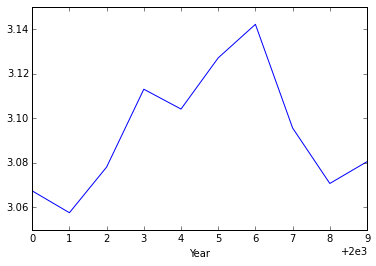

In [31]:
annual_means.plot()

### Multiple aggregations

We may also want to apply multiple aggregations, like the mean, max, and min. We can do this with the agg() method and pass a list of aggregation functions as the argument.

In [32]:
annual_summary = data_annual['wlev'].agg([np.mean,np.max,np.min])
print annual_summary

          mean  amax  amin
Year                      
2000  3.067434  5.11  0.07
2001  3.057653  5.24 -0.07
2002  3.078112  5.25  0.14
2003  3.112990  5.45 -0.09
2004  3.104097  5.14 -0.06
2005  3.127036  5.43  0.00
2006  3.142052  5.49 -0.01
2007  3.095614  5.20 -0.14
2008  3.070757  5.19 -0.12
2009  3.080533  5.20 -0.20


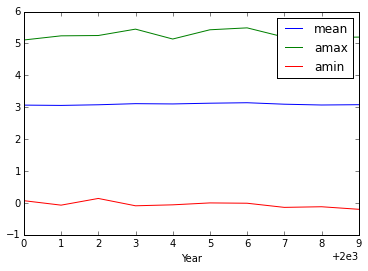

In [33]:
annual_summary.plot()

### Iterating over groups
In some instances, we may want to iterate over each group. Each group is identifed by a key. If we know the group's key, then we can access that group with the get_group() method. 

For example, for each year print the mean sea level.

In [34]:
for year in data_annual.groups.keys():
    data_year = data_annual.get_group(year)
    print  year, data_year['wlev'].mean()

2000 3.06743417303
2001 3.05765296804
2002 3.07811187215
2003 3.11298972603
2004 3.1040974832
2005 3.12703618873
2006 3.14205230699
2007 3.0956142955
2008 3.07075714448
2009 3.08053287593


We had calculated the annual mean sea level earlier, but this is another way to achieve a similar result.

###Exercise

For each year, plot the monthly mean water level.

####Solution

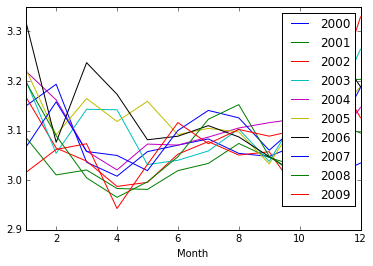

In [35]:
for year in data_annual.groups.keys():
    data_year = data_annual.get_group(year)
    month_mean = data_year.groupby('Month')['wlev'].apply(np.mean)
    month_mean.plot(label=year)
plt.legend()


###Multiple groups

We can also group by multiple columns. For example, we might want to group by year and month. That is, a year/month combo defines the group.

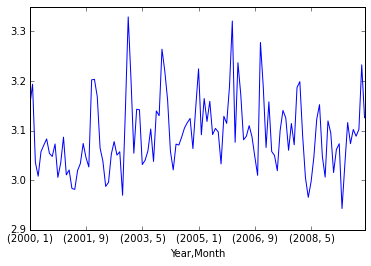

In [36]:
data_yearmonth = data.groupby(['Year','Month'])

means = data_yearmonth['wlev'].apply(np.mean)
means.plot()


##Time Series

The x-labels on the plot above are a little bit awkward. A different approach would be to resample the data at a monthly freqeuncy. This can be accomplished by setting the date column as an index. Then we can resample the data at a desired frequency. The resampling method is flexible but a common choice is the average.

First, we will need to set the index as a DatetimeIndex. Recall, the date_index variable we had assigned earlier. We will add this to the dataframe and make it into the dataframe index.

In [37]:
data['date_index'] = date_index
data.set_index('date_index', inplace=True)

Now we can resample at a monthly frequency and plot.

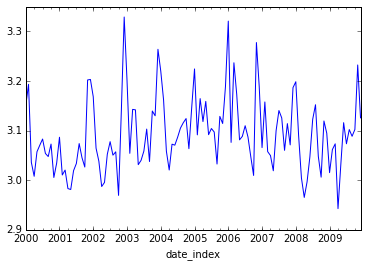

In [38]:
data_monthly = data['wlev'].resample('M', how='mean')
data_monthly.plot()

##Summary

pandas is a poweful tool for manipulating tabular data. There are many, many other features that were not discussed here. See the documentation for more features.

http://pandas.pydata.org/pandas-docs/stable/index.html